In [249]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
# algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBClassifier
# cross validation
from sklearn.model_selection import cross_val_predict
# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
# Feature Selection
from sklearn.feature_selection import RFE
# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from joblib import dump, load

# Prompt: Figure out what users will donate $20,000 over the next 5 years.

In [169]:
# Read in data
yearlydonordf = pd.read_csv('Windfall DS Challenge -- PTG/Donors.csv')
yearlydonordf.head()

,cand_id,Year,amount,Age,Start Year,End Year,Total Amount,Count,Years,Average Amount,Annual Amount,Next 5 Year Amount,Years Spent,Good Donor,Rolling Amount,Rolling Total,Rolling Average
0,candidate_0,2007,50.00,54,2007,2019,59581.81,61,13,976.750984,4583.216154,6746.89,1,0,50.00,50.00,50.000000
1,candidate_0,2009,234.39,54,2007,2019,59581.81,61,13,976.750984,4583.216154,24062.51,3,1,284.39,284.39,142.195000
2,candidate_0,2010,912.50,54,2007,2019,59581.81,61,13,976.750984,4583.216154,28650.01,4,1,1196.89,1196.89,398.963333
3,candidate_0,2011,1000.00,54,2007,2019,59581.81,61,13,976.750984,4583.216154,31400.01,5,1,2196.89,2196.89,549.222500
4,candidate_0,2012,4600.00,54,2007,2019,59581.81,61,13,976.750984,4583.216154,38409.95,6,1,6796.89,6796.89,1359.378000


In [170]:
# Remaining Data Formatting/Cleaning
donorSubsamples = len(yearlydonordf[yearlydonordf['Year'] < 2015])
donorSubsamplePct = round((100 *len(yearlydonordf[yearlydonordf['Year'] < 2015]) / len(yearlydonordf)),2)
print('Removing incomplete recent data keeps ' + str(donorSubsamples) + ' out of ' + str(len(yearlydonordf)) + ' records (' + str(donorSubsamplePct) + '%)')
yearlydonordf = yearlydonordf[['cand_id', 'Year', 'amount', 'Start Year', 'Rolling Total', 'Years Spent', 'Rolling Average','Next 5 Year Amount', 'Good Donor']]
yearlydonordf = yearlydonordf[yearlydonordf['Year'] < 2015]
yearlydonordf.head()

Removing incomplete recent data keeps 254997 out of 287933 records (88.56%)


,cand_id,Year,amount,Start Year,Rolling Total,Years Spent,Rolling Average,Next 5 Year Amount,Good Donor
0,candidate_0,2007,50.00,2007,50.00,1,50.000000,6746.89,0
1,candidate_0,2009,234.39,2007,284.39,3,142.195000,24062.51,1
2,candidate_0,2010,912.50,2007,1196.89,4,398.963333,28650.01,1
3,candidate_0,2011,1000.00,2007,2196.89,5,549.222500,31400.01,1
4,candidate_0,2012,4600.00,2007,6796.89,6,1359.378000,38409.95,1


#### Donor activity after 2014 needs to be removed since those donors haven't had a full 5 years to reach the 20k line.

AxesSubplot(0.127273,0.125;0.617727x0.755)


,Year,amount,Start Year,Rolling Total,Years Spent,Rolling Average,Next 5 Year Amount,Good Donor
count,254997.000000,2.549970e+05,254997.000000,2.549970e+05,254997.000000,2.549970e+05,2.549970e+05,254997.000000
mean,2000.232669,9.783296e+02,1994.812496,5.239334e+03,6.420174,6.175139e+02,3.998094e+03,0.019361
std,7.606923,2.968373e+04,7.604217,9.110852e+04,6.324981,1.071133e+04,8.393567e+04,0.137791
min,1900.000000,0.000000e+00,1900.000000,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000
25%,1994.000000,2.500000e+01,1989.000000,5.000000e+01,2.000000,2.500000e+01,1.000000e+01,0.000000
50%,2000.000000,5.000000e+01,1994.000000,1.500000e+02,4.000000,5.000000e+01,7.500000e+01,0.000000
75%,2006.000000,1.250000e+02,2000.000000,5.950000e+02,9.000000,1.393333e+02,3.234000e+02,0.000000
max,2014.000000,7.012995e+06,2014.000000,1.000734e+07,115.000000,1.406164e+06,1.478656e+07,1.000000


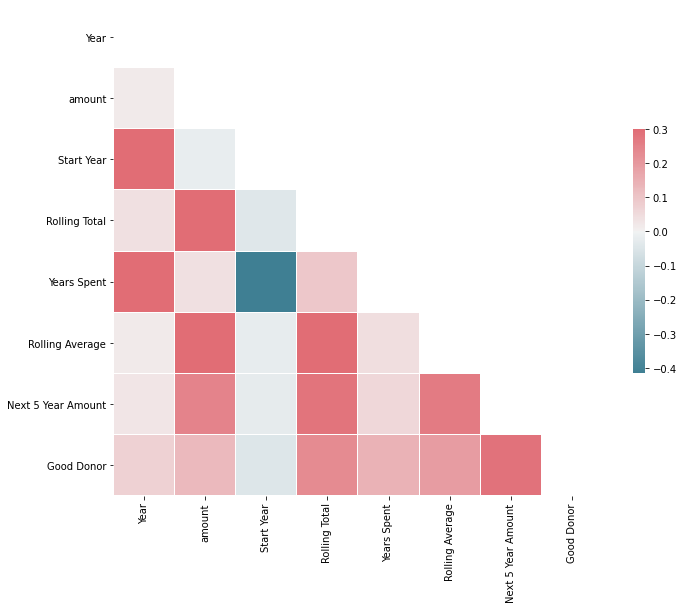

In [171]:
# High Level Yearly Donors Summary
corr = yearlydonordf.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
print(sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.01, cbar_kws={"shrink": .5}))
yearlydonordf.describe()

#### This shows that historic spending patterns (amount, Rolling Total, Rolling Average) are a good indicator of future spending (Next 5 Year Amount, Good Donor).

The desired behavior of $20k in the next 5 years has been seen 4937 out of 254997 times (1.94%)
The desired behavior of $20k in the next 5 years has been seen on 830 out of 55339 users (1.5%)

amount Mean when Future under 20k: $447.78
amount Mean when Future over 20k: $27850.54
amount Standard Deviation when Future under 20k: $23764.68
amount Standard Deviation when Future over 20k: $127168.58

Rolling Total Mean when Future under 20k: $2286.3
Rolling Total Mean when Future over 20k: $154811.3
Rolling Total Standard Deviation when Future under 20k: $45774.34
Rolling Total Standard Deviation when Future over 20k: $547590.28

Rolling Average Mean when Future under 20k: $327.71
Rolling Average Mean when Future over 20k: $15296.36
Rolling Average Standard Deviation when Future under 20k: $5740.6
Rolling Average Standard Deviation when Future over 20k: $63544.36



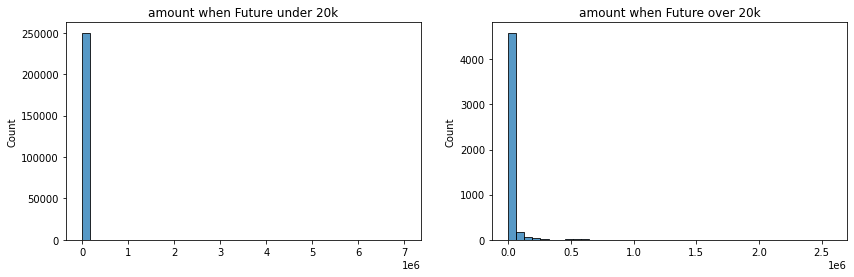

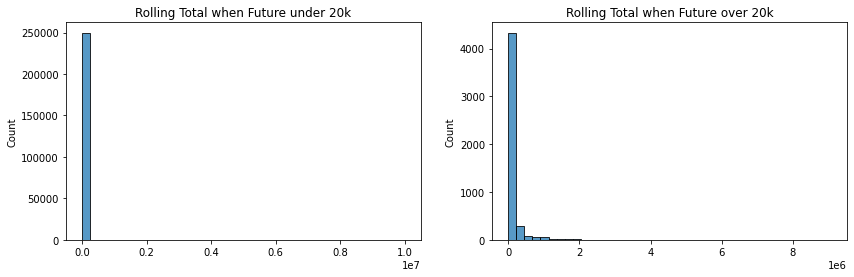

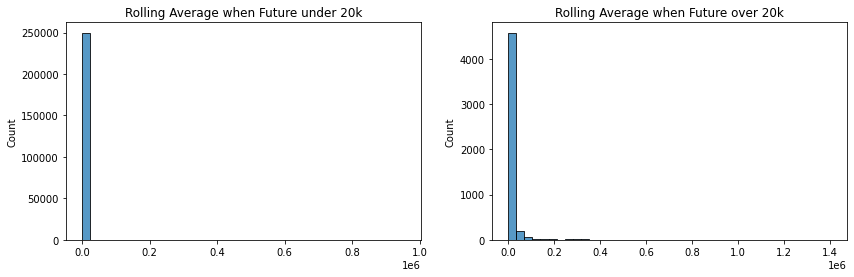

In [172]:
# Target Variable Analysis
goodbehaviordf = yearlydonordf[yearlydonordf['Good Donor'] == 1]
goodBehaviorPct = round((100 * len(goodbehaviordf) / len(yearlydonordf)), 2)
goodUserCount = len(goodbehaviordf['cand_id'].unique())
goodUserPct = round((100 * goodUserCount / len(yearlydonordf['cand_id'].unique())), 2)
print('The desired behavior of $20k in the next 5 years has been seen ' + str(len(goodbehaviordf)) + ' out of ' + str(len(yearlydonordf)) + ' times (' + str(goodBehaviorPct) + '%)')
print('The desired behavior of $20k in the next 5 years has been seen on ' + str(goodUserCount) + ' out of ' + str(len(yearlydonordf['cand_id'].unique())) + ' users (' + str(goodUserPct) + '%)')
print('')
for attribute in ['amount', 'Rolling Total', 'Rolling Average']:
    print(attribute + ' Mean when Future under 20k: $' + str(round(yearlydonordf[yearlydonordf['Next 5 Year Amount'] < 20000][attribute].mean(), 2)))
    print(attribute + ' Mean when Future over 20k: $' + str(round(yearlydonordf[yearlydonordf['Next 5 Year Amount'] >= 20000][attribute].mean(), 2)))
    print(attribute + ' Standard Deviation when Future under 20k: $' + str(round(yearlydonordf[yearlydonordf['Next 5 Year Amount'] < 20000][attribute].std(), 2)))
    print(attribute + ' Standard Deviation when Future over 20k: $' + str(round(yearlydonordf[yearlydonordf['Next 5 Year Amount'] >= 20000][attribute].std(), 2)))
    fig, ax = plt.subplots(1, 2, figsize = (14,4))
    sns.histplot(x = yearlydonordf[yearlydonordf['Next 5 Year Amount'] < 20000][attribute].values, ax = ax[0], bins = 40)
    ax[0].set_title(attribute + ' when Future under 20k', fontsize = 12)
    sns.histplot(x = yearlydonordf[yearlydonordf['Next 5 Year Amount'] >= 20000][attribute].values, ax = ax[1], bins = 40)
    ax[1].set_title(attribute + ' when Future over 20k', fontsize = 12)
    print('')

In [173]:
# Model Split Preparation
yearlydonordf = yearlydonordf.sample(frac=1, random_state=1)
yearlydonorids = yearlydonordf['cand_id'].values
yearlydonordf = yearlydonordf.drop(['cand_id'], axis=1)
split = np.split(yearlydonordf, [6], axis=1)
inputs = split[0]
target = split[1]
target.head()

,Next 5 Year Amount,Good Donor
276374,400.0,0.0
49807,0.0,0.0
161504,0.0,0.0
221197,787.0,0.0
260514,75.0,0.0


In [174]:
# Setting up Metrics
models = []
accuracyScores = []
f1Scores = [] # main metric
aucScores = []
targets = ['Under 20k', 'Over 20k']
cvsplit = 5
def addMetric(model, accuracyScore, f1Score, aucScore):
    models.append(model)
    accuracyScores.append(accuracyScore)
    f1Scores.append(f1Score)
    aucScores.append(aucScore)

## Naïve Model - Baseline

#### For the naïve model, everyone is in class 0 (under $20k in the next 5 years)

In [175]:
target['prediction'] = 0
accuracyScore = round(accuracy_score(target['Good Donor'].values, target['prediction'].values), 4)
f1Score = round(f1_score(target['Good Donor'].values, target['prediction'].values), 4)
aucScore = round(roc_auc_score(target['Good Donor'].values, target['prediction'].values), 4)
addMetric('Naïve', accuracyScore, f1Score, aucScore)
print(classification_report(target['Good Donor'].values, target['prediction'].values, target_names = targets, zero_division = 0))
print('')
print('Accuracy: ' + str(accuracyScore))
print('F1 Score: ' + str(f1Score))
print('AUC Score: ' + str(aucScore))

              precision    recall  f1-score   support

   Under 20k       0.98      1.00      0.99    250060
    Over 20k       0.00      0.00      0.00      4937

    accuracy                           0.98    254997
   macro avg       0.49      0.50      0.50    254997
weighted avg       0.96      0.98      0.97    254997


Accuracy: 0.9806
F1 Score: 0.0
AUC Score: 0.5


## Logistic Regression

In [176]:
algo = LogisticRegression()
target['prediction'] = cross_val_predict(algo, inputs.values, target['Good Donor'].values, cv=cvsplit)
accuracyScore = round(accuracy_score(target['Good Donor'].values, target['prediction'].values), 4)
f1Score = round(f1_score(target['Good Donor'].values, target['prediction'].values), 4)
aucScore = round(roc_auc_score(target['Good Donor'].values, target['prediction'].values), 4)
addMetric('Logistic Regression', accuracyScore, f1Score, aucScore)
print(classification_report(target['Good Donor'].values, target['prediction'].values, target_names = targets, zero_division = 0))
print('')
print('Accuracy: ' + str(accuracyScore))
print('F1 Score: ' + str(f1Score))
print('AUC Score: ' + str(aucScore))

              precision    recall  f1-score   support

   Under 20k       0.98      1.00      0.99    250060
    Over 20k       0.58      0.11      0.18      4937

    accuracy                           0.98    254997
   macro avg       0.78      0.55      0.58    254997
weighted avg       0.97      0.98      0.97    254997


Accuracy: 0.9812
F1 Score: 0.1781
AUC Score: 0.5519


## Naïve Bayes

In [177]:
algo = GaussianNB()
target['prediction'] = cross_val_predict(algo, inputs.values, target['Good Donor'].values, cv=cvsplit)
accuracyScore = round(accuracy_score(target['Good Donor'].values, target['prediction'].values), 4)
f1Score = round(f1_score(target['Good Donor'].values, target['prediction'].values), 4)
aucScore = round(roc_auc_score(target['Good Donor'].values, target['prediction'].values), 4)
addMetric('Naïve Bayes', accuracyScore, f1Score, aucScore)
print(classification_report(target['Good Donor'].values, target['prediction'].values, target_names = targets, zero_division = 0))
print('')
print('Accuracy: ' + str(accuracyScore))
print('F1 Score: ' + str(f1Score))
print('AUC Score: ' + str(aucScore))

              precision    recall  f1-score   support

   Under 20k       0.98      1.00      0.99    250060
    Over 20k       0.60      0.19      0.29      4937

    accuracy                           0.98    254997
   macro avg       0.79      0.59      0.64    254997
weighted avg       0.98      0.98      0.98    254997


Accuracy: 0.9819
F1 Score: 0.2905
AUC Score: 0.5945


## K Nearest Neighbors

In [178]:
algo = KNeighborsClassifier()
target['prediction'] = cross_val_predict(algo, inputs.values, target['Good Donor'].values, cv=cvsplit)
accuracyScore = round(accuracy_score(target['Good Donor'].values, target['prediction'].values), 4)
f1Score = round(f1_score(target['Good Donor'].values, target['prediction'].values), 4)
aucScore = round(roc_auc_score(target['Good Donor'].values, target['prediction'].values), 4)
addMetric('K Nearest Neighbors', accuracyScore, f1Score, aucScore)
print(classification_report(target['Good Donor'].values, target['prediction'].values, target_names = targets, zero_division = 0))
print('')
print('Accuracy: ' + str(accuracyScore))
print('F1 Score: ' + str(f1Score))
print('AUC Score: ' + str(aucScore))

              precision    recall  f1-score   support

   Under 20k       0.99      1.00      0.99    250060
    Over 20k       0.68      0.49      0.57      4937

    accuracy                           0.99    254997
   macro avg       0.84      0.74      0.78    254997
weighted avg       0.98      0.99      0.98    254997


Accuracy: 0.9857
F1 Score: 0.5696
AUC Score: 0.7427


## Extra Trees

In [179]:
algo = ExtraTreesClassifier()
target['prediction'] = cross_val_predict(algo, inputs.values, target['Good Donor'].values, cv=cvsplit)
accuracyScore = round(accuracy_score(target['Good Donor'].values, target['prediction'].values), 4)
f1Score = round(f1_score(target['Good Donor'].values, target['prediction'].values), 4)
aucScore = round(roc_auc_score(target['Good Donor'].values, target['prediction'].values), 4)
addMetric('Extra Trees', accuracyScore, f1Score, aucScore)
print(classification_report(target['Good Donor'].values, target['prediction'].values, target_names = targets, zero_division = 0))
print('')
print('Accuracy: ' + str(accuracyScore))
print('F1 Score: ' + str(f1Score))
print('AUC Score: ' + str(aucScore))

              precision    recall  f1-score   support

   Under 20k       0.99      1.00      0.99    250060
    Over 20k       0.80      0.64      0.71      4937

    accuracy                           0.99    254997
   macro avg       0.89      0.82      0.85    254997
weighted avg       0.99      0.99      0.99    254997


Accuracy: 0.9899
F1 Score: 0.71
AUC Score: 0.8186


## XGBoost

In [180]:
algo = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
target['prediction'] = cross_val_predict(algo, inputs.values, target['Good Donor'].values, cv=cvsplit)
accuracyScore = round(accuracy_score(target['Good Donor'].values, target['prediction'].values), 4)
f1Score = round(f1_score(target['Good Donor'].values, target['prediction'].values), 4)
aucScore = round(roc_auc_score(target['Good Donor'].values, target['prediction'].values), 4)
addMetric('XGBoost', accuracyScore, f1Score, aucScore)
print(classification_report(target['Good Donor'].values, target['prediction'].values, target_names = targets, zero_division = 0))
print('')
print('Accuracy: ' + str(accuracyScore))
print('F1 Score: ' + str(f1Score))
print('AUC Score: ' + str(aucScore))

              precision    recall  f1-score   support

   Under 20k       0.99      1.00      0.99    250060
    Over 20k       0.76      0.51      0.61      4937

    accuracy                           0.99    254997
   macro avg       0.88      0.75      0.80    254997
weighted avg       0.99      0.99      0.99    254997


Accuracy: 0.9874
F1 Score: 0.6103
AUC Score: 0.7523


# Results

In [181]:
summary = np.array([accuracyScores, f1Scores, aucScores])
summary = summary.T
summarydf = pd.DataFrame(summary, columns =['Accuracy', 'F1', 'AUC'])
summarydf.index = models
summarydf = summarydf.sort_values(by='F1', ascending=False)
summarydf

,Accuracy,F1,AUC
Extra Trees,0.9899,0.7100,0.8186
XGBoost,0.9874,0.6103,0.7523
K Nearest Neighbors,0.9857,0.5696,0.7427
Naïve Bayes,0.9819,0.2905,0.5945
Logistic Regression,0.9812,0.1781,0.5519
Naïve,0.9806,0.0000,0.5000


In [182]:
improvedAcc = round((summarydf['Accuracy'].values[0] - summarydf['Accuracy'].values[-1]), 4)
improvedAccPct = round(((100*(summarydf['Accuracy'].values[0]/summarydf['Accuracy'].values[-1]))-100), 2)
bestAlgo = summarydf.index[0]
print('The result accuracy improved by ' + str(improvedAcc) + ' (' + str(improvedAccPct) + '%) from ' + str(summarydf['Accuracy'].values[-1]) + ' to ' + str(summarydf['Accuracy'].values[0]) + ' with the help of ' + bestAlgo)

The result accuracy improved by 0.0093 (0.95%) from 0.9806 to 0.9899 with the help of Extra Trees


#### Based on the metrics displayed above, Extra Trees seems to be the best ML Algo with an F1 Score of .7100. Extra Trees also boasts an Accuracy Score .95% higher than the Naïve baseline.

# Enhanced Modeling with Windfall_features

In [183]:
# Augmenting the Features
otherfeaturesdf = pd.read_csv('Windfall DS Challenge -- PTG/windfall_features.csv')
yearlydonordf['cand_id'] = yearlydonorids
fullyearlydonordf = otherfeaturesdf.merge(yearlydonordf, left_on='candidate_id', right_on='cand_id')
fullyearlydonordf.sort_values(by=['cand_id', 'Years Spent'])

,candidate_id,totalHouseholdDebt,primaryPropertyLoanToValue,primaryPropertyValue,propertyCount,isClassADonor,isClassBDonor,isClassCDonor,isClassDDonor,NetWorth,...,sumCauseEDonations,Year,amount,Start Year,Rolling Total,Years Spent,Rolling Average,Next 5 Year Amount,Good Donor,cand_id
5,candidate_0,6.085778,0.336380,2215000.0,4.0,0.0,0.0,1.0,1.0,14011369.0,...,0.0,2007,50.00,2007,50.00,1,50.000000,6746.89,0,candidate_0
2,candidate_0,6.085778,0.336380,2215000.0,4.0,0.0,0.0,1.0,1.0,14011369.0,...,0.0,2009,234.39,2007,284.39,3,142.195000,24062.51,1,candidate_0
4,candidate_0,6.085778,0.336380,2215000.0,4.0,0.0,0.0,1.0,1.0,14011369.0,...,0.0,2010,912.50,2007,1196.89,4,398.963333,28650.01,1,candidate_0
1,candidate_0,6.085778,0.336380,2215000.0,4.0,0.0,0.0,1.0,1.0,14011369.0,...,0.0,2011,1000.00,2007,2196.89,5,549.222500,31400.01,1,candidate_0
0,candidate_0,6.085778,0.336380,2215000.0,4.0,0.0,0.0,1.0,1.0,14011369.0,...,0.0,2012,4600.00,2007,6796.89,6,1359.378000,38409.95,1,candidate_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27151,candidate_9997,5.664685,0.426318,1083805.0,1.0,0.0,1.0,0.0,1.0,1563987.0,...,0.0,2005,1650.00,2001,8850.00,5,2212.500000,0.00,0,candidate_9997
181318,candidate_99971,5.984077,0.820378,1175068.0,1.0,0.0,0.0,0.0,0.0,1172203.0,...,0.0,2014,50.00,2014,50.00,1,50.000000,50.00,0,candidate_99971
27154,candidate_9998,6.049027,0.353904,2322000.0,3.0,0.0,1.0,1.0,0.0,14007797.0,...,0.0,2014,250.00,2014,250.00,1,250.000000,2000.00,0,candidate_9998
27156,candidate_9999,5.964673,0.339429,2139645.0,2.0,0.0,1.0,1.0,1.0,5564561.0,...,0.0,1992,3063.75,1992,3063.75,1,3063.750000,400.00,0,candidate_9999


In [184]:
# Null Analysis
nullcounts = []
nullpcts = []
for attribute in otherfeaturesdf.columns.values:
    attributedf = otherfeaturesdf[[attribute]]
    nullcount = len(attributedf) - len(attributedf.dropna())
    nullcounts.append(nullcount)
    nullpct = round((100 * nullcount/len(otherfeaturesdf)), 2)
    nullpcts.append(nullpct)
nullsdf = pd.DataFrame([nullcounts, nullpcts], columns = otherfeaturesdf.columns.values)
nullsdf.index = ['Null Counts', 'Null Percents']
nullsdf = nullsdf.T
nullsdf.sort_values(by='Null Percents', ascending=False)

,Null Counts,Null Percents
sumClassBDonation,79195.0,60.87
sumClassCDonation,79195.0,60.87
sumCauseDDonations,79195.0,60.87
sumCauseCDonations,79195.0,60.87
sumCauseBDonations,79195.0,60.87
sumCauseADonations,79195.0,60.87
maxClassDDonation,79195.0,60.87
maxClassCDonation,79195.0,60.87
maxClassBDonation,79195.0,60.87
maxClassADonation,79195.0,60.87


In [185]:
# Null Removal
nullct = len(fullyearlydonordf) - len(fullyearlydonordf.dropna())
nullpct = round((100 * nullct/len(fullyearlydonordf)), 2)
print('There are ' + str(nullct) + ' null columns in this dataset. (' + str(nullpct) + '%)')
fullyearlydonordf = fullyearlydonordf.dropna()

There are 134706 null columns in this dataset. (52.83%)


#### It appears as though there is a lot of missing data here, so around half the data needs be removed.

AxesSubplot(0.127273,0.125;0.617727x0.755)


,totalHouseholdDebt,primaryPropertyLoanToValue,primaryPropertyValue,propertyCount,isClassADonor,isClassBDonor,isClassCDonor,isClassDDonor,NetWorth,sumClassADonation,...,sumCauseDDonations,sumCauseEDonations,Year,amount,Start Year,Rolling Total,Years Spent,Rolling Average,Next 5 Year Amount,Good Donor
count,120291.000000,120291.000000,1.202910e+05,120291.000000,120291.000000,120291.000000,120291.000000,120291.000000,1.202910e+05,1.202910e+05,...,120291.000000,120291.000000,120291.000000,1.202910e+05,120291.000000,1.202910e+05,120291.000000,120291.000000,1.202910e+05,120291.000000
mean,4.101253,0.174354,1.346151e+06,1.445395,0.001580,0.602406,0.296972,0.225154,6.075575e+06,2.147955e+03,...,0.566431,0.008784,2002.214355,8.317944e+02,1996.020982,4.947687e+03,7.193373,569.369232,4.473676e+03,0.027658
std,2.230649,0.216615,1.208537e+06,0.965943,0.039712,0.489403,0.456926,0.417685,6.673783e+07,1.105892e+05,...,0.993815,0.179400,7.473303,1.227935e+04,7.952137,4.332597e+04,6.924466,4718.379376,9.316481e+04,0.163991
min,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00,...,0.000000,0.000000,1900.000000,0.000000e+00,1900.000000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000
25%,4.023993,0.000002,6.888000e+05,1.000000,0.000000,0.000000,0.000000,0.000000,1.285610e+06,1.000000e+00,...,0.000000,0.000000,1997.000000,2.500000e+01,1990.000000,7.000000e+01,2.000000,26.000000,2.000000e+01,0.000000
50%,5.134311,0.096757,1.006397e+06,1.000000,0.000000,1.000000,0.000000,0.000000,2.498510e+06,1.000000e+00,...,0.000000,0.000000,2003.000000,5.000000e+01,1995.000000,2.050000e+02,5.000000,60.000000,1.000000e+02,0.000000
75%,5.558569,0.270020,1.596368e+06,2.000000,0.000000,1.000000,1.000000,0.000000,5.282610e+06,1.000000e+00,...,1.204120,0.000000,2008.000000,1.750000e+02,2002.000000,9.000000e+02,11.000000,180.298500,5.380000e+02,0.000000
max,7.156278,1.917606,2.756721e+07,21.000000,1.000000,1.000000,1.000000,1.000000,5.965655e+09,1.417200e+07,...,5.996560,5.787978,2014.000000,2.275565e+06,2014.000000,3.439702e+06,115.000000,302631.525000,1.478656e+07,1.000000


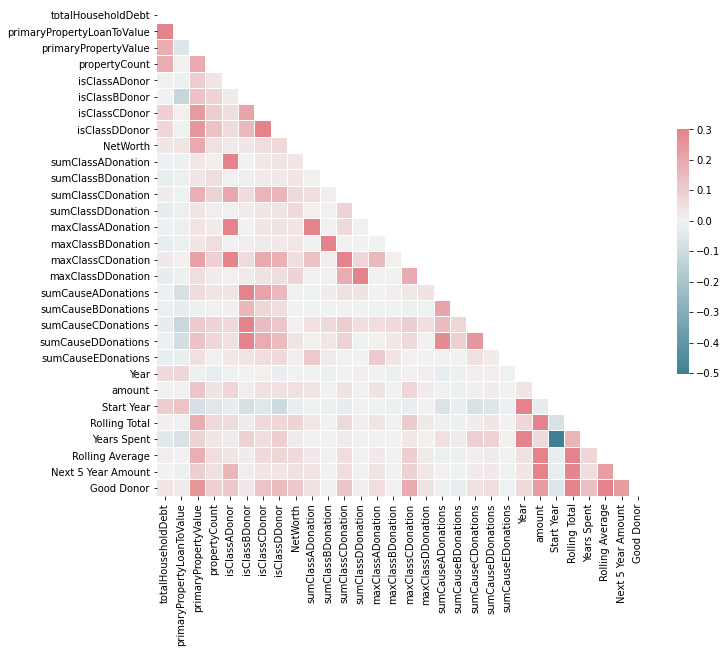

In [186]:
# High Level Full Yearly Donors Summary
corr = fullyearlydonordf.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
print(sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.01, cbar_kws={"shrink": .5}))
fullyearlydonordf.describe()

In [187]:
# Model Split Preparation
fullyearlydonordf = fullyearlydonordf.sample(frac=1, random_state=1)
fullyearlydonordf = fullyearlydonordf.drop(['candidate_id', 'cand_id'], axis=1)
split = np.split(fullyearlydonordf, [(len(fullyearlydonordf.columns.values)-2)], axis=1)
inputs = split[0]
target = split[1]
target.head()

,Next 5 Year Amount,Good Donor
210077,550.0,0.0
8075,45.0,0.0
231937,100.0,0.0
215488,1994.6,0.0
22565,0.0,0.0


In [188]:
# Setting up Metrics
models = []
accuracyScores = []
f1Scores = [] # main metric
aucScores = []

## Naïve Model - Baseline

In [189]:
target['prediction'] = 0
accuracyScore = round(accuracy_score(target['Good Donor'].values, target['prediction'].values), 4)
f1Score = round(f1_score(target['Good Donor'].values, target['prediction'].values), 4)
aucScore = round(roc_auc_score(target['Good Donor'].values, target['prediction'].values), 4)
addMetric('Naïve', accuracyScore, f1Score, aucScore)
print(classification_report(target['Good Donor'].values, target['prediction'].values, target_names = targets, zero_division = 0))
print('')
print('Accuracy: ' + str(accuracyScore))
print('F1 Score: ' + str(f1Score))
print('AUC Score: ' + str(aucScore))

              precision    recall  f1-score   support

   Under 20k       0.97      1.00      0.99    116964
    Over 20k       0.00      0.00      0.00      3327

    accuracy                           0.97    120291
   macro avg       0.49      0.50      0.49    120291
weighted avg       0.95      0.97      0.96    120291


Accuracy: 0.9723
F1 Score: 0.0
AUC Score: 0.5


## Logistic Regression

In [190]:
algo = LogisticRegression()
target['prediction'] = cross_val_predict(algo, inputs.values, target['Good Donor'].values, cv=cvsplit)
accuracyScore = round(accuracy_score(target['Good Donor'].values, target['prediction'].values), 4)
f1Score = round(f1_score(target['Good Donor'].values, target['prediction'].values), 4)
aucScore = round(roc_auc_score(target['Good Donor'].values, target['prediction'].values), 4)
addMetric('Logistic Regression', accuracyScore, f1Score, aucScore)
print(classification_report(target['Good Donor'].values, target['prediction'].values, target_names = targets, zero_division = 0))
print('')
print('Accuracy: ' + str(accuracyScore))
print('F1 Score: ' + str(f1Score))
print('AUC Score: ' + str(aucScore))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

   Under 20k       0.98      0.99      0.99    116964
    Over 20k       0.50      0.27      0.35      3327

    accuracy                           0.97    120291
   macro avg       0.74      0.63      0.67    120291
weighted avg       0.97      0.97      0.97    120291


Accuracy: 0.9723
F1 Score: 0.3501
AUC Score: 0.6311


## Naïve Bayes

In [191]:
algo = GaussianNB()
target['prediction'] = cross_val_predict(algo, inputs.values, target['Good Donor'].values, cv=cvsplit)
accuracyScore = round(accuracy_score(target['Good Donor'].values, target['prediction'].values), 4)
f1Score = round(f1_score(target['Good Donor'].values, target['prediction'].values), 4)
aucScore = round(roc_auc_score(target['Good Donor'].values, target['prediction'].values), 4)
addMetric('Naïve Bayes', accuracyScore, f1Score, aucScore)
print(classification_report(target['Good Donor'].values, target['prediction'].values, target_names = targets, zero_division = 0))
print('')
print('Accuracy: ' + str(accuracyScore))
print('F1 Score: ' + str(f1Score))
print('AUC Score: ' + str(aucScore))

              precision    recall  f1-score   support

   Under 20k       0.98      0.99      0.99    116964
    Over 20k       0.54      0.43      0.48      3327

    accuracy                           0.97    120291
   macro avg       0.76      0.71      0.73    120291
weighted avg       0.97      0.97      0.97    120291


Accuracy: 0.9743
F1 Score: 0.482
AUC Score: 0.7111


## K Nearest Neighbors

In [192]:
algo = KNeighborsClassifier()
target['prediction'] = cross_val_predict(algo, inputs.values, target['Good Donor'].values, cv=cvsplit)
accuracyScore = round(accuracy_score(target['Good Donor'].values, target['prediction'].values), 4)
f1Score = round(f1_score(target['Good Donor'].values, target['prediction'].values), 4)
aucScore = round(roc_auc_score(target['Good Donor'].values, target['prediction'].values), 4)
addMetric('K Nearest Neighbors', accuracyScore, f1Score, aucScore)
print(classification_report(target['Good Donor'].values, target['prediction'].values, target_names = targets, zero_division = 0))
print('')
print('Accuracy: ' + str(accuracyScore))
print('F1 Score: ' + str(f1Score))
print('AUC Score: ' + str(aucScore))

              precision    recall  f1-score   support

   Under 20k       0.99      1.00      0.99    116964
    Over 20k       0.82      0.75      0.78      3327

    accuracy                           0.99    120291
   macro avg       0.91      0.87      0.89    120291
weighted avg       0.99      0.99      0.99    120291


Accuracy: 0.9886
F1 Score: 0.7836
AUC Score: 0.871


## Extra Trees

In [193]:
algo = ExtraTreesClassifier()
target['prediction'] = cross_val_predict(algo, inputs.values, target['Good Donor'].values, cv=cvsplit)
accuracyScore = round(accuracy_score(target['Good Donor'].values, target['prediction'].values), 4)
f1Score = round(f1_score(target['Good Donor'].values, target['prediction'].values), 4)
aucScore = round(roc_auc_score(target['Good Donor'].values, target['prediction'].values), 4)
addMetric('Extra Trees', accuracyScore, f1Score, aucScore)
print(classification_report(target['Good Donor'].values, target['prediction'].values, target_names = targets, zero_division = 0))
print('')
print('Accuracy: ' + str(accuracyScore))
print('F1 Score: ' + str(f1Score))
print('AUC Score: ' + str(aucScore))

              precision    recall  f1-score   support

   Under 20k       1.00      1.00      1.00    116964
    Over 20k       0.91      0.85      0.88      3327

    accuracy                           0.99    120291
   macro avg       0.95      0.92      0.94    120291
weighted avg       0.99      0.99      0.99    120291


Accuracy: 0.9936
F1 Score: 0.8798
AUC Score: 0.9238


## XGBoost

In [194]:
algo = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
target['prediction'] = cross_val_predict(algo, inputs.values, target['Good Donor'].values, cv=cvsplit)
accuracyScore = round(accuracy_score(target['Good Donor'].values, target['prediction'].values), 4)
f1Score = round(f1_score(target['Good Donor'].values, target['prediction'].values), 4)
aucScore = round(roc_auc_score(target['Good Donor'].values, target['prediction'].values), 4)
addMetric('XGBoost', accuracyScore, f1Score, aucScore)
print(classification_report(target['Good Donor'].values, target['prediction'].values, target_names = targets, zero_division = 0))
print('')
print('Accuracy: ' + str(accuracyScore))
print('F1 Score: ' + str(f1Score))
print('AUC Score: ' + str(aucScore))

              precision    recall  f1-score   support

   Under 20k       0.99      1.00      1.00    116964
    Over 20k       0.89      0.77      0.82      3327

    accuracy                           0.99    120291
   macro avg       0.94      0.88      0.91    120291
weighted avg       0.99      0.99      0.99    120291


Accuracy: 0.9909
F1 Score: 0.8232
AUC Score: 0.8823


# Results

In [195]:
summary = np.array([accuracyScores, f1Scores, aucScores])
summary = summary.T
summarydf = pd.DataFrame(summary, columns =['Accuracy', 'F1', 'AUC'])
summarydf.index = models
summarydf = summarydf.sort_values(by='F1', ascending=False)
summarydf

,Accuracy,F1,AUC
Extra Trees,0.9936,0.8798,0.9238
XGBoost,0.9909,0.8232,0.8823
K Nearest Neighbors,0.9886,0.7836,0.8710
Naïve Bayes,0.9743,0.4820,0.7111
Logistic Regression,0.9723,0.3501,0.6311
Naïve,0.9723,0.0000,0.5000


In [196]:
improvedAcc = round((summarydf['Accuracy'].values[0] - summarydf['Accuracy'].values[-1]), 4)
improvedAccPct = round(((100*(summarydf['Accuracy'].values[0]/summarydf['Accuracy'].values[-1]))-100), 2)
bestAlgo = summarydf.index[0]
print('The result accuracy improved by ' + str(improvedAcc) + ' (' + str(improvedAccPct) + '%) from ' + str(summarydf['Accuracy'].values[-1]) + ' to ' + str(summarydf['Accuracy'].values[0]) + ' with the help of ' + bestAlgo)

The result accuracy improved by 0.0213 (2.19%) from 0.9723 to 0.9936 with the help of Extra Trees


#### Based on the metrics displayed above, Extra Trees seems to be the best ML Algo with an F1 Score of .8798. Extra Trees also boasts an Accuracy Score 2.19% higher than the Naïve baseline.

# Feature Removal

In [206]:
# Ranking Attributes
algo = ExtraTreesClassifier()
rfe = RFE(algo, n_features_to_select = 1)
ranking = rfe.fit(inputs.values, target['Good Donor'].values)
rankdf = pd.DataFrame((inputs.columns.values), columns=['Attribute'])
rankdf['Ranking'] = ranking.ranking_
rankdf = rankdf.sort_values('Ranking', ascending=True)
rankdf = rankdf.set_index('Ranking')
rankdf

,Attribute
Ranking,
1,Rolling Average
2,Rolling Total
3,amount
4,primaryPropertyValue
5,NetWorth
6,maxClassCDonation
7,Years Spent
8,totalHouseholdDebt
9,Start Year


In [212]:
# Setting up Metrics
models = []
accuracyScores = []
f1Scores = [] # main metric
aucScores = []

In [213]:
# Top Algo on Feature Subsets
attributes = rankdf['Attribute'].values
for attct in range(len(attributes)):
    attset = attributes[:attct+1]
    algo = ExtraTreesClassifier()
    target['prediction'] = cross_val_predict(algo, inputs[attset].values, target['Good Donor'].values, cv=cvsplit)
    accuracyScore = round(accuracy_score(target['Good Donor'].values, target['prediction'].values), 4)
    f1Score = round(f1_score(target['Good Donor'].values, target['prediction'].values), 4)
    aucScore = round(roc_auc_score(target['Good Donor'].values, target['prediction'].values), 4)
    addMetric('Top ' + str(attct+1), accuracyScore, f1Score, aucScore)

In [214]:
topfeatures = np.array([accuracyScores, f1Scores, aucScores])
topfeatures = topfeatures.T
topfeaturesdf = pd.DataFrame(topfeatures, columns =['Accuracy', 'F1', 'AUC'])
topfeaturesdf.index = models
topfeaturesdf = topfeaturesdf.sort_values(by='F1', ascending=False)
topfeaturesdf

,Accuracy,F1,AUC
Top 23,0.9936,0.8807,0.9249
Top 24,0.9935,0.8779,0.9235
Top 25,0.9934,0.8771,0.9224
Top 27,0.9934,0.8767,0.9226
Top 22,0.9934,0.8765,0.9221
Top 28,0.9934,0.8759,0.9218
Top 26,0.9933,0.8752,0.9214
Top 21,0.9933,0.8749,0.9214
Top 20,0.9933,0.8732,0.9180
Top 19,0.9931,0.8712,0.9179


In [223]:
topInputs = inputs[attributes[:23]]
improvedAcc = round((topfeaturesdf['Accuracy'].values[0] - topfeaturesdf['Accuracy'].values[-1]), 4)
improvedAccPct = round(((100*(topfeaturesdf['Accuracy'].values[0]/topfeaturesdf['Accuracy'].values[-1]))-100), 2)
bestAlgo = topfeaturesdf.index[0]
print('The result accuracy improved by ' + str(improvedAcc) + ' (' + str(improvedAccPct) + '%) from ' + str(topfeaturesdf['Accuracy'].values[-1]) + ' to ' + str(topfeaturesdf['Accuracy'].values[0]) + ' by limiting the input to the ' + bestAlgo + ' features')

The result accuracy improved by 0.0165 (1.69%) from 0.9771 to 0.9936 by limiting the input to the Top 23 features


#### Based on the metrics displayed above, the 23 feature model looks optimal with an F1 Score of .8807. The 23 feature model also boasts an Accuracy Score 1.69% higher than the 1 feature model.

# Hyperparameter Optimization

In [226]:
# Simple Grid Search
parameters = {'criterion':['gini', 'entropy'], 'max_features':['sqrt', 'log2'], 'bootstrap':[True, False]}
algo = ExtraTreesClassifier()
gridSearch = GridSearchCV(algo, parameters)
gridSearch.fit(topInputs.values, target['Good Donor'].values)

GridSearchCV(estimator=ExtraTreesClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2']})

In [233]:
print('The best hyperparams are: ' + str(gridSearch.best_params_))
algo = ExtraTreesClassifier(bootstrap = False, criterion = 'entropy', max_features = 'sqrt')
target['prediction'] = cross_val_predict(algo, topInputs.values, target['Good Donor'].values, cv=cvsplit)
accuracyScore = round(accuracy_score(target['Good Donor'].values, target['prediction'].values), 4)
f1Score = round(f1_score(target['Good Donor'].values, target['prediction'].values), 4)
aucScore = round(roc_auc_score(target['Good Donor'].values, target['prediction'].values), 4)
print(classification_report(target['Good Donor'].values, target['prediction'].values, target_names = targets, zero_division = 0))
print('')
print('Accuracy: ' + str(accuracyScore))
print('F1 Score: ' + str(f1Score))
print('AUC Score: ' + str(aucScore))

The best hyperparams are: {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt'}
              precision    recall  f1-score   support

   Under 20k       1.00      1.00      1.00    116964
    Over 20k       0.91      0.86      0.88      3327

    accuracy                           0.99    120291
   macro avg       0.95      0.93      0.94    120291
weighted avg       0.99      0.99      0.99    120291


Accuracy: 0.9936
F1 Score: 0.8815
AUC Score: 0.9274


#### 0.8815 is the highest F1 Score produced by these experiments.

| Model | Description | Accuracy | F1 Score | AUC Score |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| **Naïve** | Predicted 0 for Everything | 0.9806 | 0.0000 | 0.5000 |
| **Basic** | Extra Trees | 0.9899 | 0.7100 | 0.8186 |
| **Extended Attributes** | Basic + More Attributes  | 0.9936 | 0.8798 | 0.9238 |
| **Feature Optimized** | Extended Attributes - Unnecessary Attributes | 0.9936 | 0.8807 | 0.9249 |
| **Hyperparameter Optimized** | Feature Optimized + modified criterion | 0.9936 | 0.8815 | 0.9274 |

Final Model: **ExtraTreesClassifier with 23 Attributes and {bootstrap = False, criterion = 'entropy', max_features = 'sqrt'}**

In [236]:
# Save Final Model
algo = ExtraTreesClassifier(bootstrap = False, criterion = 'entropy', max_features = 'sqrt')
algo.fit(topInputs.values, target['Good Donor'].values)
dump(algo, 'Windfall DS Challenge -- PTG/finalModel.joblib')

['Windfall DS Challenge -- PTG/finalModel.joblib']

# Propensity Model

#### A propensity model gives users a probability score based on the inputs recorded. Since the target is always either 1 or 0, using a regressor instead of a classifier should return the probability of 1.

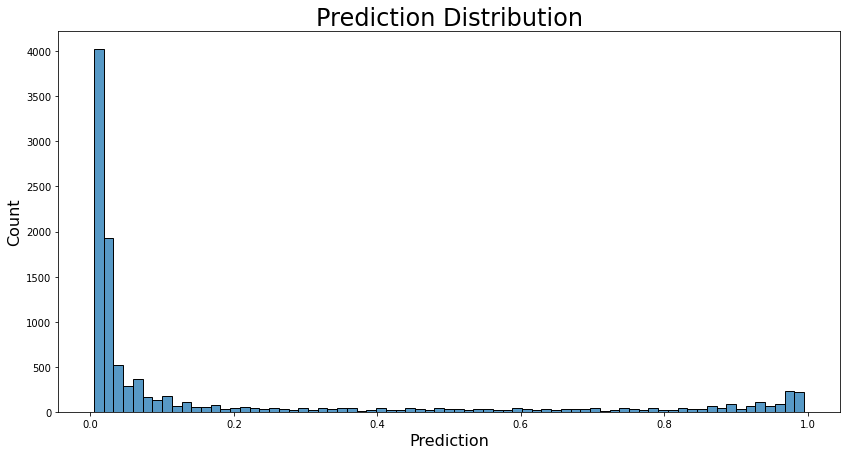

In [254]:
algo = ExtraTreesRegressor(max_features = 'sqrt')
target['prediction'] = cross_val_predict(algo, topInputs.values, target['Good Donor'].values, cv=cvsplit)
fig, ax = plt.subplots(figsize = (14,7))
plt.title('Prediction Distribution', fontsize = 24)
sns.histplot(x = target[(target['prediction'] > 0) & (target['prediction'] < 1)]['prediction'].values, ax = ax)
plt.xlabel('Prediction', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.show()

In [255]:
# Save Final Propensity Model
algo = ExtraTreesRegressor(max_features = 'sqrt')
algo.fit(topInputs.values, target['Good Donor'].values)
dump(algo, 'Windfall DS Challenge -- PTG/finalPropensityModel.joblib')

['Windfall DS Challenge -- PTG/finalPropensityModel.joblib']